In [1]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import matplotlib

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("matplotlib", matplotlib.__version__)

gammapy: 0.19
numpy: 1.19.2
astropy 4.0.2
regions 0.4
matplotlib 3.3.2


In [2]:
%matplotlib inline
import os
import numpy as np
import scipy
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
from matplotlib.offsetbox import AnchoredText
from pathlib import Path
from regions import CircleSkyRegion

from gammapy.maps import Map, RegionGeom
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    MapDataset,
    FluxPointsDataset
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel, LogParabolaSpectralModel
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.makers.utils import make_theta_squared_table
from gammapy.visualization import plot_theta_squared_table
import pickle

ImportError: cannot import name 'Regions' from 'regions' (C:\Users\33695\anaconda3\lib\site-packages\regions\__init__.py)

In [ ]:
location_data = '/home/lavergne/Téléchargements/hess_dl3_dr1/' #path to DL3 folder
source_name = 'Crab' #e.g., Crab, GRB210807A
cut_type = 'loose' #e.g., loose, hard, ...
filename_output = '{name}_{cut}'.format(name=source_name, cut=cut_type)

In [ ]:
source_position = SkyCoord.from_name(source_name)
max_offset_run = 2.5 * u.deg

In [ ]:
#If not existing create folder to store the images in the current folder
work_directory = os.getcwd()
path_plot = Path(work_directory+"/figures")
path_plot.mkdir(exist_ok=True)
path_results = Path(work_directory+"/results")
path_results.mkdir(exist_ok=True)

In [ ]:
on_radius = 0.2 * u.deg
exclusion_radius = 0.35*u.deg

In [ ]:
e_min_reco = 0.02 * u.TeV
e_max_reco = 10. * u.TeV
n_bin_per_decade_e_reco = 10

e_min_true = 0.005 * u.TeV
e_max_true = 40. * u.TeV
n_bin_per_decade_e_true = 20

e_min_flux_point = 0.02 * u.TeV
e_max_flux_point = 10.0 * u.TeV
n_bin_per_decade_flux_point = 5

# Temporary gammapy fix

In [3]:
def plot_excess(dataset_to_plot,
                ax=None,
                kwargs_excess=None,
                kwargs_npred_signal=None,
                **kwargs):
    from gammapy.stats import WStatCountsStatistic, CashCountsStatistic
    region=None
    
    kwargs_excess = kwargs_excess or {}
    kwargs_npred_signal = kwargs_npred_signal or {}
    
    counts, npred = dataset_to_plot.counts.copy(), dataset_to_plot.npred()

    if dataset_to_plot.mask is None:
        mask = dataset_to_plot.copy()
        mask.data = 1
    else:
        mask = dataset_to_plot.mask
    counts *= mask
    npred *= mask
    
    if dataset_to_plot.stat_type == "wstat":
        counts_off = (dataset_to_plot.counts_off * mask)
        with np.errstate(invalid="ignore"):
            alpha = (dataset_to_plot.alpha * mask)

        stat = WStatCountsStatistic(
            n_on=counts,
            n_off=counts_off,
            alpha=alpha,
            #mu_sig=npred,
        )
    elif dataset_to_plot.stat_type == "cash":
        stat = CashCountsStatistic(counts.data, npred.data)

    yerr = np.zeros((2, ) + counts.data.shape)
    yerr[0], yerr[1] = -stat.compute_errn(), stat.compute_errp()
    yerr = stat.error

    plot_kwargs = kwargs.copy()
    plot_kwargs.update(kwargs_excess)
    plot_kwargs.setdefault("label", "Excess counts")
    ax = dataset_to_plot.excess.plot(ax, yerr=yerr, **plot_kwargs)

    plot_kwargs = kwargs.copy()
    plot_kwargs.update(kwargs_npred_signal)
    plot_kwargs.setdefault("label", "Predicted signal counts")
    dataset_to_plot.npred_signal().plot_hist(ax, **plot_kwargs)

    ax.legend(numpoints=1)
    return ax
    
def plot_fit(
        dataset_to_plot,
        ax_spectrum=None,
        ax_residuals=None,
        kwargs_spectrum=None,
        kwargs_residuals=None,
    ):
    from matplotlib.gridspec import GridSpec
    from gammapy.datasets.utils import get_axes

    gs = GridSpec(7, 1)
    ax_spectrum, ax_residuals = get_axes(
        ax_spectrum,
        ax_residuals,
        8,
        7,
        [gs[:5, :]],
        [gs[5:, :]],
        kwargs2={"sharex": ax_spectrum},
    )
    kwargs_spectrum = kwargs_spectrum or {}
    kwargs_residuals = kwargs_residuals or {}

    plot_excess(dataset_to_plot, ax_spectrum, **kwargs_spectrum)

    dataset_to_plot.plot_residuals_spectral(ax_residuals, **kwargs_residuals)

    method = kwargs_residuals.get("method", "diff")
    label = dataset_to_plot._residuals_labels[method]
    ax_residuals.set_ylabel(f"Residuals\n{label}")

    return ax_spectrum, ax_residuals

# Load Data

In [9]:
data_store = DataStore.from_dir(location_data)

In [10]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/lavergne/Téléchargements/hess_dl3_dr1
Rows: 525
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [11]:
data_store.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47802,330.29538,-30.225555,17.818897,-52.742733,36.828686,53.171314,110.0,PKS 2155-304,329.71667,-30.225555,0.50002956,1688.0,1572.4065,0.9315204,241558291.0,241559979.0,2008-08-27,19:32:35.184,2008-08-27,20:00:43.184,4,"1,2,3,4",0,0.9731573,5998,PKS 2155-304 (steady),pks2155_steady,0.4998021,0.61659503,100.0


In [12]:
#Select all runs automatically, otherwise specify single runs.
#obs_ids = [5543, 5544, 5545]
obs_ids = data_store.obs_table[source_position.separation(data_store.obs_table.pointing_radec) < max_offset_run]['OBS_ID']
obs_collection = data_store.get_observations(obs_ids, required_irf=None)

No HDU found matching: OBS_ID = 23523, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23526, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23559, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 23592, HDU_TYPE = rad_max, HDU_CLASS = None


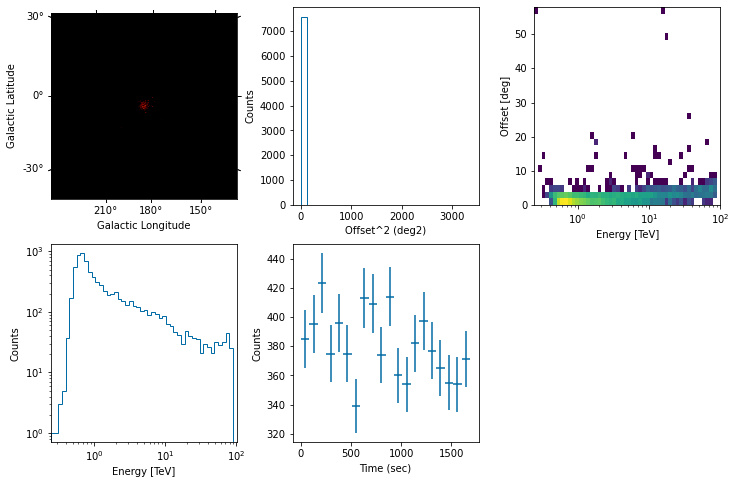

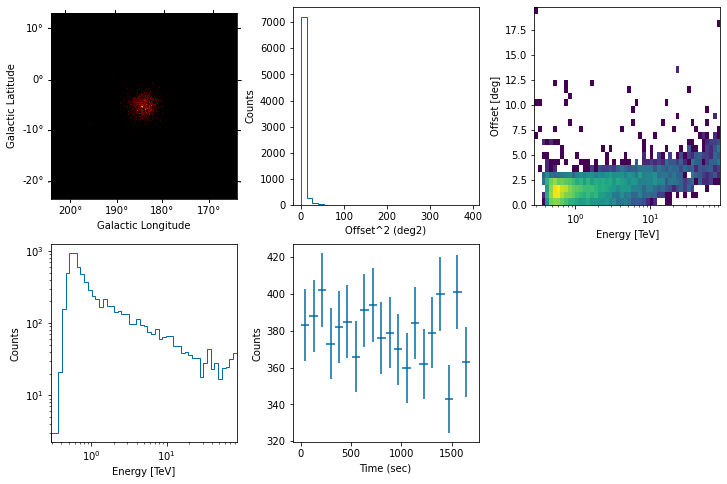

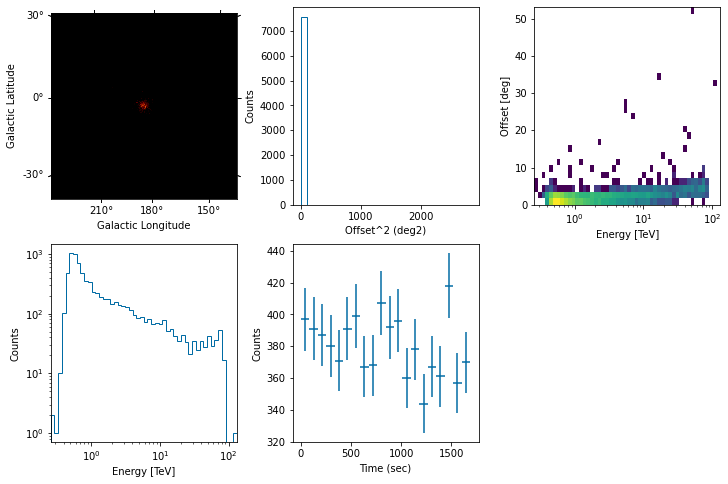

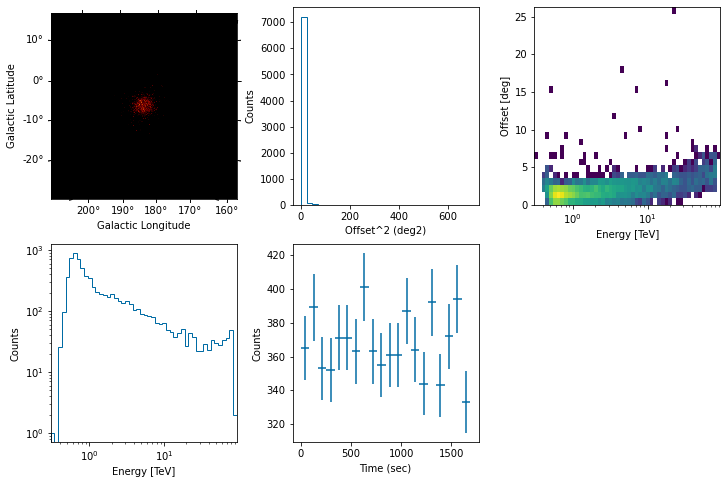

In [13]:
for i in range(len(obs_collection)):
    obs_collection[i].events.peek()

# Define on Region and exclusion region

In [14]:
on_region = CircleSkyRegion(center=source_position, radius=on_radius)
exclude_region = CircleSkyRegion(center=source_position, radius=exclusion_radius)

In [15]:
n_bin_energy_reco = int((np.log10(e_max_reco.to_value(u.TeV))-np.log10(e_min_reco.to_value(u.TeV)))*n_bin_per_decade_e_reco)
energy_axis_reco = MapAxis.from_edges(
    np.logspace(np.log10(e_min_reco.to_value(u.TeV)), np.log10(e_max_reco.to_value(u.TeV)), n_bin_energy_reco), unit="TeV", name="energy", interp="log"
)
n_bin_energy_true = int((np.log10(e_max_true.to_value(u.TeV))-np.log10(e_min_true.to_value(u.TeV)))*n_bin_per_decade_e_true)
energy_axis_true = MapAxis.from_edges(
    np.logspace(np.log10(e_min_true.to_value(u.TeV)), np.log10(e_max_true.to_value(u.TeV)), n_bin_energy_true), unit="TeV", name="energy_true", interp="log"
)

In [16]:
geom_on_region = RegionGeom.create(region=on_region, axes=[energy_axis_reco])
geom = WcsGeom.create(
    skydir=source_position, npix=(200, 200), binsz=0.02, frame="icrs", axes=[energy_axis_reco], 
)
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (200, 200, 25)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 4.0 deg x 4.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

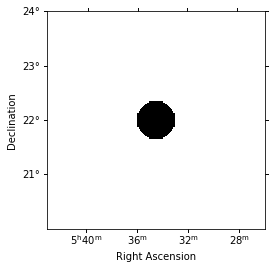

In [17]:
geom_image = geom.to_image()
exclusion_mask = ~geom_image.region_mask([exclude_region])
exclusion_mask.sum_over_axes().plot();

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


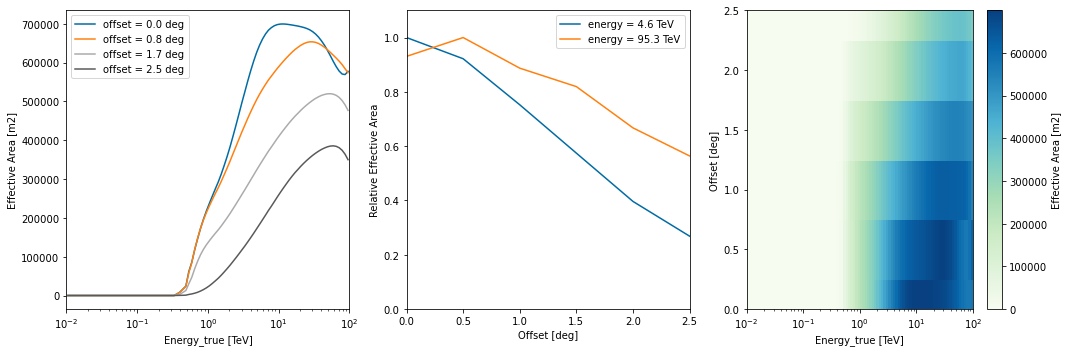

In [18]:
if obs_collection[0].aeff is not None:
    obs_collection[0].aeff.peek()

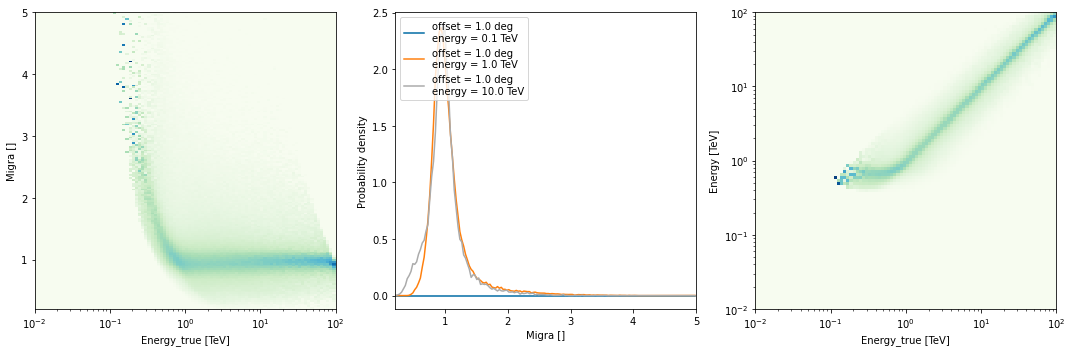

In [19]:
if obs_collection[0].edisp is not None:
    obs_collection[0].edisp.peek()

In [20]:
if obs_collection[0].bkg is not None:
    obs_collection[0].bkg.peek()

# Spectral Fitting

In [21]:
dataset_maker_spectrum = SpectrumDatasetMaker(selection=["counts", "exposure", "edisp"], use_region_center=True)
spectrum_dataset_empty = SpectrumDataset.create(geom=geom_on_region, energy_axis_true=energy_axis_true)
bkg_maker_spectrum = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

dataset_stacked_map = MapDataset.create(geom=geom, name=source_name+'_stacked')
map_dataset_maker = MapDatasetMaker(selection=["counts"])
map_maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max="4 deg")

datasets_spectrum_joint = Datasets()
for obs in obs_collection:
    dataset_spectrum = dataset_maker_spectrum.run(spectrum_dataset_empty.copy(name=f"obs-{obs.obs_id}"), obs)
    dataset_on_off_spectrum = bkg_maker_spectrum.run(observation=obs, dataset=dataset_spectrum)
    datasets_spectrum_joint.append(dataset_on_off_spectrum)
    
    map_cutout = dataset_stacked_map.cutout(obs.pointing_radec, width="6.5 deg")
    map_dataset = map_dataset_maker.run(map_cutout, obs)
    map_dataset = map_maker_safe_mask.run(map_dataset, obs)
    dataset_stacked_map.stack(map_dataset)
    
info_table = datasets_spectrum_joint.info_table(cumulative=True)

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


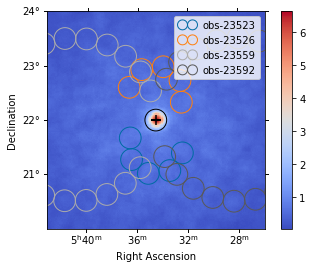

In [22]:
#plt.figure(figsize=(8, 8))
ax = dataset_stacked_map.to_image().counts.smooth('0.12 deg', kernel='disk').plot(add_cbar=True, cmap='coolwarm')
on_region.to_pixel(ax.wcs).plot(ax=ax, color='black')
plot_spectrum_datasets_off_regions(datasets=datasets_spectrum_joint, ax=ax)
plt.gca().scatter(source_position.ra, source_position.dec, transform=plt.gca().get_transform('world'), marker='+', c='k', label=source_name, s=[100])
plt.show()

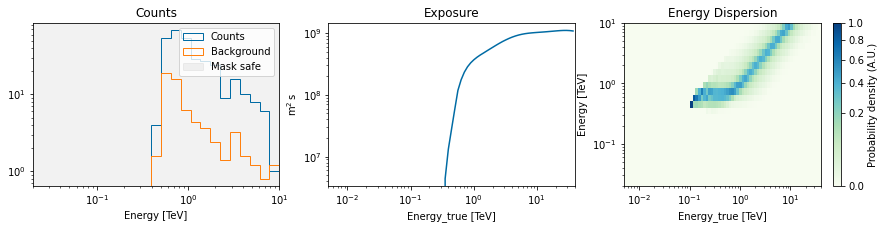

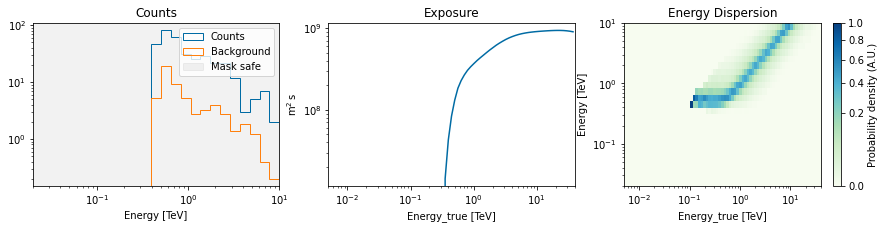

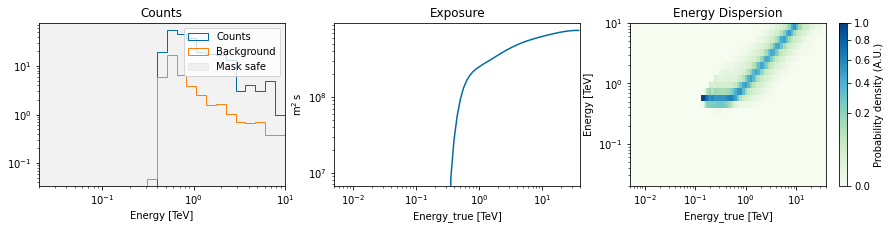

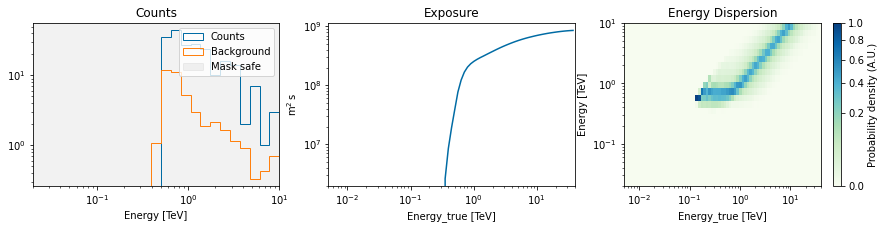

In [23]:
for dataset in datasets_spectrum_joint:
    plt.figure(figsize=(15, 3))
    dataset.peek()

In [24]:
reference_energy = energy_axis_reco.center[int(energy_axis_reco.nbin/2)]
spectral_model = {'power_law': PowerLawSpectralModel(amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
                                                     index=2,
                                                     reference=reference_energy),
                  'log_parabola': LogParabolaSpectralModel(amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
                                                           alpha=2,
                                                           beta=0,
                                                           reference=reference_energy),
                  'power_law_exponantial_cutoff': ExpCutoffPowerLawSpectralModel(amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
                                                                                 index=2,
                                                                                 lambda_=1./reference_energy,
                                                                                 reference=reference_energy)
                 }
model = {}
for k in spectral_model.keys():
    model[k] = SkyModel(spectral_model=spectral_model[k], name=source_name+'_'+k)

In [25]:
datasets_spectrum_joint_with_model = {}
datasets_spectrum_joint_with_model_stacked = {}
fit_joint = {}
result_fit_joint = {}
for k in spectral_model.keys():
    datasets_spectrum_joint_with_model[k] = datasets_spectrum_joint.copy()
    datasets_spectrum_joint_with_model[k].models = [model[k]]
    fit_joint[k] = Fit()
    result_fit_joint[k] = fit_joint[k].run(datasets=datasets_spectrum_joint_with_model[k])
    
    datasets_spectrum_joint_with_model_stacked[k] = datasets_spectrum_joint_with_model[k].stack_reduce()
    datasets_spectrum_joint_with_model_stacked[k].models = [model[k]]

/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/lavergne/software/miniconda3/envs/lst-analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [26]:
for k in spectral_model.keys():
    if not result_fit_joint[k].success:
        print('Fit of '+k+' didn\' converge')

In [ ]:
if result_fit_joint['power_law_exponantial_cutoff'].total_stat > result_fit_joint['log_parabola'].total_stat:
    chalenger_model = 'log_parabola'
    print('Log parabola perform better than power law than exponantial cut off')
else:
    chalenger_model = 'power_law_exponantial_cutoff'
    print('Power law than exponantial cut off perform better than log parabola')
 

#significance_chalenger = np.sqrt((result_fit_joint['power_law'].total_stat-result_fit_joint[chalenger_model].total_stat))
print('\n\nLikelihood Ratio test\n')
LR_statistic = result_fit_joint['power_law'].total_stat-result_fit_joint[chalenger_model].total_stat
dof = 1
p_val = scipy.stats.chi2.sf(LR_statistic, dof)

significance_chalenger = np.sqrt(2) * scipy.special.erfinv(1 - p_val)
print('The significance of the {} model over power law is {:.5f} sigma'.format(chalenger_model, significance_chalenger))

if significance_chalenger > 5.:
    selected_model = chalenger_model
    print('The spectral model ' + chalenger_model +' is selected as significant')
else:
    selected_model = 'power_law'
    print('The spectral model ' + chalenger_model +' is rejected as not significant over power law')
    print('The selected spectral model is the power law')

(1.4560604, 298.70483655318947)

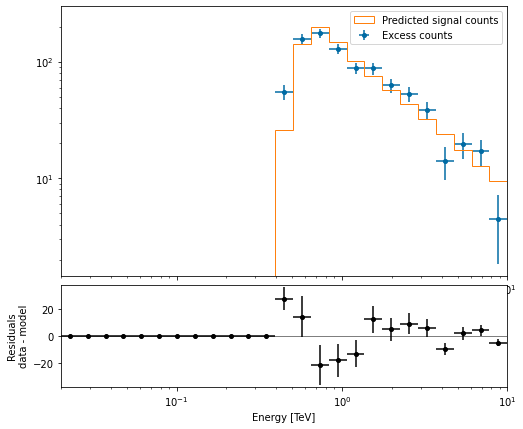

In [28]:
ax1, ax2 = plot_fit(datasets_spectrum_joint_with_model_stacked[k])
excess = datasets_spectrum_joint_with_model_stacked[k].excess.data
n_on = datasets_spectrum_joint_with_model_stacked[k].counts.data
n_off = datasets_spectrum_joint_with_model_stacked[k].counts_off.data
alpha = datasets_spectrum_joint_with_model_stacked[k].alpha.data
low_excess = excess-np.sqrt(n_on+alpha*alpha*n_off)
low_excess = low_excess[low_excess>0.]
ax1.set_ylim(bottom = np.min(0.8*low_excess))

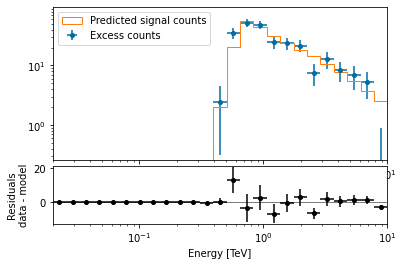

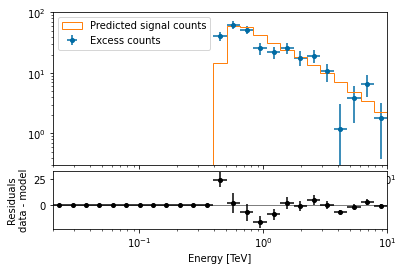

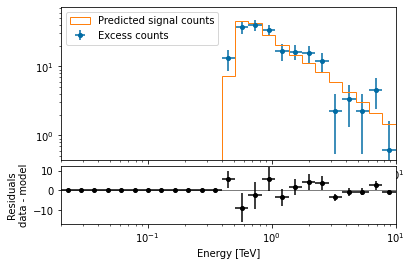

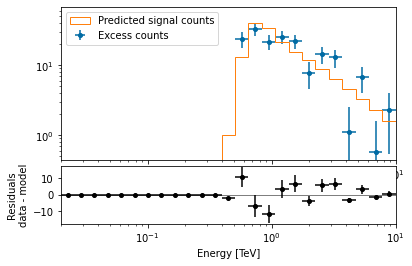

In [29]:
for dataset in datasets_spectrum_joint_with_model[selected_model]:
    plt.figure()
    ax1, ax2 = plot_fit(dataset)
    excess = dataset.excess.data
    n_on = dataset.counts.data
    n_off = dataset.counts_off.data
    alpha = dataset.alpha.data
    low_excess = excess-np.sqrt(n_on+alpha*alpha*n_off)
    low_excess = low_excess[low_excess>0.]
    ax1.set_ylim(bottom = np.min(0.8*low_excess))

In [30]:
print(datasets_spectrum_joint_with_model[selected_model].models)

DatasetModels

Component 0: SkyModel

  Name                      : Crab_power_law
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                   :      2.734   +/-    0.06             
    amplitude               :   3.66e-10   +/- 2.5e-11 1 / (cm2 s TeV)
    reference    (frozen)   :      0.447       TeV         




In [31]:
datasets_spectrum_joint_with_model[selected_model].models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str14,str8,str9,float64,str14,float64,float64,float64,bool,str1
Crab_power_law,spectral,index,2.7337e+00,,6.310e-02,nan,nan,False,
Crab_power_law,spectral,amplitude,3.6606e-10,cm-2 s-1 TeV-1,2.503e-11,nan,nan,False,
Crab_power_law,spectral,reference,4.4721e-01,TeV,0.000e+00,nan,nan,True,


# Flux point

In [32]:
n_bin_energy_flux_point = int((np.log10(e_max_flux_point.to_value(u.TeV))-np.log10(e_min_flux_point.to_value(u.TeV)))*n_bin_per_decade_flux_point)
energy_edges_flux_point = np.logspace(np.log10(e_min_flux_point.to_value(u.TeV)), np.log10(e_max_flux_point.to_value(u.TeV)), n_bin_energy_flux_point)*u.TeV

In [33]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges_flux_point, source=source_name+'_'+selected_model, selection_optional="all", n_sigma_ul=3, reoptimize=False
)
flux_points = fpe.run(datasets=datasets_spectrum_joint_with_model[selected_model])

In [34]:
flux_points.to_table(sed_type="e2dnde", formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [4],npred_excess [4],stat,is_ul,counts [4],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.026,0.020,0.033,nan,nan,nan,nan,nan,0.000,-0.000,0.0 .. 0.0,0.0 .. 0.0,0.000,True,0.0 .. 0.0,False,0.200 .. 5.000,0.000 .. 0.000
0.042,0.033,0.054,nan,nan,nan,nan,nan,0.000,-0.000,0.0 .. 0.0,0.0 .. 0.0,0.000,True,0.0 .. 0.0,False,0.200 .. 5.000,0.000 .. 0.000
0.069,0.054,0.089,nan,nan,nan,nan,nan,0.000,-0.000,0.0 .. 0.0,0.0 .. 0.0,0.000,True,0.0 .. 0.0,False,0.200 .. 5.000,0.000 .. 0.000
0.114,0.089,0.146,nan,nan,nan,nan,nan,0.000,-0.000,0.0 .. 0.0,0.0 .. 0.0,0.000,True,0.0 .. 0.0,False,0.200 .. 5.000,0.000 .. 0.000
0.187,0.146,0.240,nan,nan,nan,nan,nan,0.000,-0.000,0.0 .. 0.0,0.0 .. 0.0,0.000,True,0.0 .. 0.0,False,0.200 .. 5.000,0.000 .. 0.000
0.308,0.240,0.395,nan,nan,nan,nan,nan,-0.000,-0.000,0.0 .. -2.407412430484045e-35,-1.1066549e-18 .. -1.3835462e-19,0.093,True,0.0 .. 0.0,False,0.200 .. 5.000,0.113 .. 0.591
0.573,0.395,0.833,6.356e-11,3.863e-12,3.919e-12,3.807e-12,7.566e-11,551.712,23.489,118.96403778795798 .. 80.29525171046596,81.58981 .. 55.722458,40.486,False,126.0 .. 80.0,True,0.200 .. 5.000,337.692 .. 1523.416
1.068,0.833,1.369,3.334e-11,2.448e-12,2.499e-12,2.398e-12,4.114e-11,451.088,21.239,76.5074549804057 .. 55.67647843240876,65.71987 .. 47.447723,11.597,False,83.0 .. 55.0,True,0.200 .. 5.000,210.335 .. 1273.840


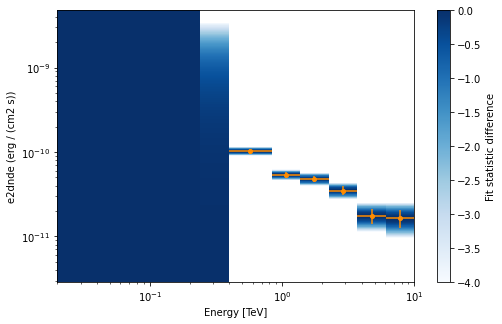

In [35]:
plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.savefig(os.path.join(path_plot,'{}__flux_point.png'.format(filename_output)), dpi=300)

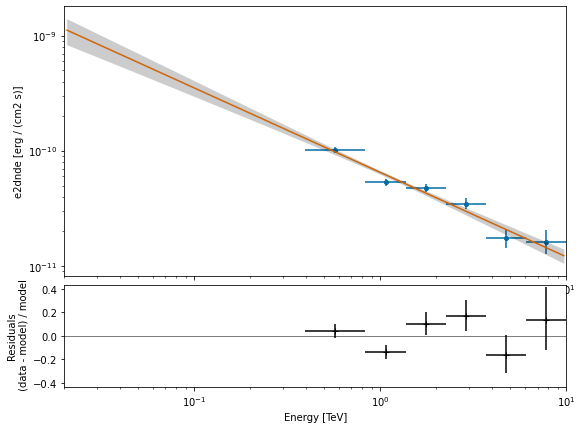

In [36]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model[selected_model]
)
flux_points_dataset.plot_fit()
plt.savefig(os.path.join(path_plot,'{}__spectra.png'.format(filename_output)), dpi=300)

In [37]:
with open(os.path.join(path_results, '{}__best_spectral_model.pickle'.format(filename_output)), mode='wb') as f:
    pickle.dump({'model':model[selected_model].copy(source_name)}, f)